In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')

## glassdoor data cleaning

In [5]:
glassdoor = pd.read_csv('glassdoor.csv')
## company column: remove 'Company - '
glassdoor['company'].replace(regex = True, inplace=True,to_replace='Company -', value='')

## revenue column: extract numbers + million/billion
#  % timeit: list comprehension, then apply function

glassdoor['revenue'] = [x.strip('\(USD\) per year | per year') for x in glassdoor.revenue]
glassdoor['revenue'] = glassdoor.revenue.apply(lambda x: x.replace('to', '-'))

glassdoor['min_USD'] = glassdoor.revenue.str.extract("(million)", expand = True)
glassdoor['max_USD'] = glassdoor.revenue.str.extract("(billion)", expand=True)
glassdoor['max_USD'] = glassdoor.max_USD.fillna(value=glassdoor.min_USD)
glassdoor['min_USD'] = glassdoor.max_USD.fillna(value=glassdoor.max_USD)
glassdoor['revenue'] = [x.strip(' million | billion') for x in glassdoor.revenue]

glassdoor['revenue'].replace(regex=True, inplace=True, to_replace='[$]', value="")
glassdoor['revenue'].replace(inplace=True, to_replace=['Less than 1'], value='1')
glassdoor['revenue'].replace(regex=True, inplace=True, to_replace='[+]', value="")
glassdoor['revenue'].replace(inplace=True, to_replace='500 million - 1', value='500-1')

glassdoor['revenue'].replace(inplace=True, to_replace=('known / Non-Applica'), value = np.nan)

glassdoor['min'] = glassdoor.revenue.str.extract('(\d+)', expand = True)

     
## size column: extract numbers
glassdoor['size'].replace(regex=True, inplace=True, to_replace=('employees'), value='')
# title column: remove Overview
glassdoor['title'].replace(regex=True, inplace=True, to_replace=('Overview'), value='')

glassdoor.columns = ['company', 'industry', 'revenue', 'employees', 'name', 'min_USD', 'max_USD',
       'min']

glassdoor.to_csv('glassdoor_cleaned.csv')

## attacks by employee (%)

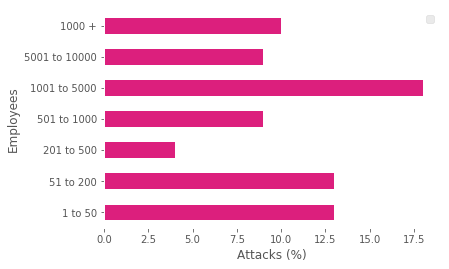

In [74]:
# better version with perc as y axis
glassdoor_employee_perc = glassdoor.groupby('employees').agg({"company": "count"})
glassdoor_employee_perc['perc'] = (glassdoor_employee_perc['company']*100)/76

#df for custom order
new_df = pd.DataFrame({'Employees': ['1 to 50','51 to 200','201 to 500','501 to 1000','1001 to 5000', '5001 to 10000','1000 +'],
           'Attacks (%)': [13,13,4,9,18,9,10]})

#plot
new_df.set_index('Employees').plot.barh(color = '#dc1f7d')
ax = plt.gca()
ax.set_facecolor('white')
plt.xlabel('Attacks (%)')
plt.legend('')

plt.savefig('attacks_employee.png')

## attacks by revenue (%)

In [8]:
# define function to ctageorize revenue range

def grouping(row):
    if row['min'] == '1' and row['max_USD'] == 'billion':
        return 'above 1 billion'
    
    if row['min'] == '100':
        return '100 to 500 million'
    
    if row['min'] == '500':
        return '500 to 1000 million'
        
    if row['min'] == '1' and row["max_USD"] == 'million':
        return '1 to 10 million'
    
    if row['min'] == '50':
        return '50 to 100 million'
    
    if row['min'] == '10' or row['min'] == '25':
        return '10 to 50 million'
    
    if pd.isna(row['min']):
        return np.nan
    
    else:
        return '1 to 10 million'

In [11]:
# apply function to dataset
glassdoor['revenue_range'] = glassdoor.apply(lambda row: grouping(row), axis = 1)

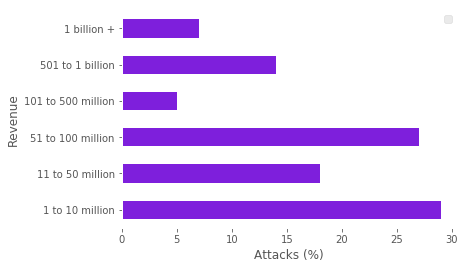

In [75]:
# define new column
glassdoor_revenue_perc = glassdoor.groupby('revenue_range').agg({"company": "count"})
glassdoor_revenue_perc['perc'] = (glassdoor_revenue_perc['company']*100)/56

#df for custom order
new_df_r = pd.DataFrame({'Revenue':['1 to 10 million','11 to 50 million','51 to 100 million','101 to 500 million','501 to 1 billion','1 billion +'],
                         'attacks (%)': [29, 18,27,5,14,7]
                        })
new_df_r.set_index('Revenue').plot.barh(color='#7e1fdc')
ax = plt.gca()
ax.set_facecolor('white')
plt.xlabel('Attacks (%)')

plt.legend('')

plt.savefig('attacks_revenue.png')

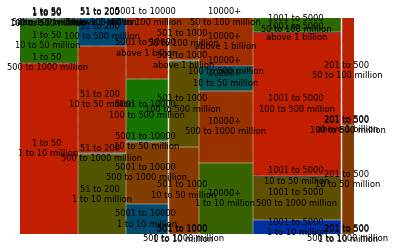

In [21]:
# define function for chi square
from scipy.stats import chi2_contingency

def chisq_of_df_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    return(chi2_contingency(ctsum.fillna(0)))


chisq_of_df_cols(glassdoor, 'employees', 'revenue_range')

from statsmodels.graphics.mosaicplot import mosaic
dummy = mosaic(glassdoor, ['employees', 'revenue_range'], statistic=True, axes_label=False)
plt.figure(figsize = (30, 30), facecolor = None)

plt.savefig('mosaic.png')

In [ ]:
# glassdoor company list
list_comp = ['City of Farmington',
"Florida's Agency for Health Care Administration (FAHCA)",
'Health South-East RHF', 
'Onco360', 
'Adams Health Network', 
'Hancock Regional Hospital',
'Singing River Health System', 
'Partners HealthCare System',
'Smith Dental', 
'Decatur County General Hospital',
'University of Virginia Health System (uvahealth.com)', 
'FastHealth', 
'Greyhealth Group', 
'Primary Health Care',
"St. Peter's Surgery & Endoscopy Center", 
'ATI Physical Therapy',
'Finger Lakes Health',
'CareFirst BlueCross BlueShield',
'Guardian Pharmacy of Jacksonville',
'Texas Health Resources',
'UnityPoint Health',
"California's Center for Orthopaedic Specialists (COS)",
'Sangamo Therapeutics',
'Billings Clinic',
 'The Oregon Clinic',
'LifeBridge Health and LifeBridge Potomac Professionals',
'Allied Physicians',
'Aultman Health Foundation',
 'MyHeritage',
'RISE Wisconsin',
'Elmcroft Senior Living', 
'HealthEquity',
'Med Associates',
'Black River Medical Center',
 'Carepartners',
 'Humana',
'Emory Brain Health Center',
'Barts health trust',
'University of Maryland School of Medicine',
'Sentara Healthcare',
'Campbell County Health', 
'Verity Health System', 'NHS',
'Citizens Memorial Hospital',
'Lexington Medical Center',
'Family Service Rochester',
'Metropolitan Urology Group',
 'ABCD Pediatrics',
'Greenway Health',
'Diamond Institute for Infertility and Menopause',
'Prairie Mountain Health',
'Fast Health', 'Waverly Health Center',
'Cleveland Medical Associates', 
'Medicare',
'University of Vermont Medical Center',
'Plastic Surgery Associates',
'Kaleida Health',
'Surgical Dermatology Group',
'Pacific Alliance Medical Center', 
'Medical Oncology Hematology Consultants',
'Hand Rehabilitation Specialists',
'Community Memorial Health System',
'Children’s Hospital Colorado',
'Augusta Medical Center',
'Morehead Memorial Hospital',
'Rivermend Health',
'Namaste Health Care',
'Chase Brexton Health Care',
'FirstHealth',
'Catholic Charities',
'UPMC Susquehanna',
'Baptist Health Louisville',
'Colorado Center for Reproductive Medicine Minneapolis',
'Henry Ford Health System',
'Sinai Health System',
'Midland Memorial Hospital',
'Medhost',
'Colorado Mental Health Institute']
len(list_comp)

In [ ]:
# urls for glassdoor scraping
urls = ["https://www.glassdoor.com/Overview/Working-at-City-of-Farmington-NM-EI_IE665372.11,32.htm",
"https://www.glassdoor.com/Overview/Working-at-AHCA-EI_IE41744.11,15.htm",
"https://www.glassdoor.com/Overview/Working-at-South-East-Alaska-Regional-Health-Consortium-EI_IE634972.11,55.htm",
"https://www.glassdoor.com/Overview/Working-at-Onco360-EI_IE964733.11,18.htm",
"https://www.glassdoor.com/Overview/Working-at-Adams-Health-Network-EI_IE884998.11,31.htm",
"https://www.glassdoor.com/Overview/Working-at-Hancock-Regional-Hospital-EI_IE121713.11,36.htm",
"https://www.glassdoor.com/Overview/Working-at-Singing-River-Health-System-EI_IE672078.11,38.htm",
"https://www.glassdoor.com/Overview/Working-at-Partners-HealthCare-EI_IE6284.11,30.htm",
"https://www.glassdoor.com/Overview/Working-at-Smith-Dental-EI_IE1724350.11,23.htm",
"https://www.glassdoor.com/Overview/Working-at-Decatur-County-General-Hospital-EI_IE1632723.11,42.htm",
"https://www.glassdoor.com/Overview/Working-at-University-of-Virginia-Health-System-EI_IE19755.11,47.htm",
"https://www.glassdoor.com/Overview/Working-at-FastHealth-EI_IE1351010.11,21.htm",
"https://www.glassdoor.com/Overview/Working-at-greyhealth-group-EI_IE17361.11,27.htm",
"https://www.glassdoor.com/Overview/Working-at-Primary-Health-Care-EI_IE702406.11,30.htm",
"https://www.glassdoor.com/Overview/Working-at-St-Peter-s-Hospital-EI_IE306840.11,30.htm",
"https://www.glassdoor.com/Overview/Working-at-ATI-Physical-Therapy-EI_IE299225.11,31.htm",
"https://www.glassdoor.com/Overview/Working-at-Finger-Lakes-Health-EI_IE853044.11,30.htm",
"https://www.glassdoor.com/Overview/Working-at-CareFirst-BlueCross-BlueShield-EI_IE269607.11,41.htm",
"https://www.glassdoor.com/Overview/Working-at-Guardian-Pharmacy-EI_IE342332.11,28.htm",
"https://www.glassdoor.com/Overview/Working-at-Texas-Health-Resources-EI_IE7647.11,33.htm",
"https://www.glassdoor.com/Overview/Working-at-UnityPoint-Health-EI_IE18460.11,28.htm",
"https://www.glassdoor.com/Overview/Working-at-Center-for-Orthopaedic-Specialists-EI_IE1184436.11,45.htm",
"https://www.glassdoor.com/Overview/Working-at-Sangamo-Therapeutics-EI_IE11523.11,31.htm",
"https://www.glassdoor.com/Overview/Working-at-Billings-Clinic-EI_IE17438.11,26.htm",
"https://www.glassdoor.com/Overview/Working-at-The-Oregon-Clinic-EI_IE264257.11,28.htm",
"https://www.glassdoor.com/Overview/Working-at-LifeBridge-Health-EI_IE21518.11,28.htm",
"https://www.glassdoor.com/Overview/Working-at-Allied-Physicians-Group-EI_IE1159475.11,34.htm",
"https://www.glassdoor.com/Overview/Working-at-Aultman-Health-Foundation-EI_IE18927.11,36.htm",
"https://www.glassdoor.com/Overview/Working-at-MyHeritage-EI_IE765167.11,21.htm",
"https://www.glassdoor.com/Overview/Working-at-RISE-WI-EI_IE1947812.11,18.htm",
"https://www.glassdoor.com/Overview/Working-at-Elmcroft-Senior-Living-EI_IE651530.11,33.htm",
"https://www.glassdoor.com/Overview/Working-at-HealthEquity-Inc-EI_IE199470.11,27.htm",
"https://www.glassdoor.com/Overview/Working-at-Med-Associates-EI_IE653608.11,25.htm",
"https://www.glassdoor.com/Overview/Working-at-Black-River-Medical-Center-EI_IE1833449.11,37.htm",
"https://www.glassdoor.com/Overview/Working-at-CarePartners-EI_IE453635.11,23.htm",
"https://www.glassdoor.com/Overview/Working-at-Humana-EI_IE340.11,17.htm",
"https://www.glassdoor.com/Overview/Working-at-Emory-Healthcare-EI_IE19564.11,27.htm",
"https://www.glassdoor.com/Overview/Working-at-Barts-Health-NHS-Trust-EI_IE694160.11,33.htm",
"https://www.glassdoor.com/Overview/Working-at-University-of-Maryland-School-of-Medicine-EI_IE507044.11,52.htm",
"https://www.glassdoor.com/Overview/Working-at-Sentara-Healthcare-EI_IE4681.11,29.htm",
"https://www.glassdoor.com/Overview/Working-at-Campbell-County-Memorial-Hospital-EI_IE121465.11,44.htm",
"https://www.glassdoor.com/Overview/Working-at-Verity-Health-System-EI_IE1199906.11,31.htm",
"https://www.glassdoor.com/Overview/Working-at-NHS-EI_IE12873.11,14.htm",
"https://www.glassdoor.com/Overview/Working-at-Citizens-Memorial-Healthcare-EI_IE261939.11,39.htm",
"https://www.glassdoor.com/Overview/Working-at-Lexington-Medical-Center-EI_IE19688.11,35.htm",
"https://www.glassdoor.com/Overview/Working-at-Family-Service-EI_IE145040.11,25.htm",
"https://www.glassdoor.com/Overview/Working-at-Metropolitan-Urological-Specialists-EI_IE1012379.11,46.htm",
"https://www.glassdoor.com/Overview/Working-at-ABCD-Pediatrics-EI_IE1588325.11,26.htm",
"https://www.glassdoor.com/Overview/Working-at-Greenway-Health-EI_IE17401.11,26.htm",
"https://www.glassdoor.com/Overview/Working-at-Diamond-Institute-for-Infertil-EI_IE280481.11,41.htm",
"https://www.glassdoor.com/Overview/Working-at-Prairie-Mountain-Health-EI_IE1093978.11,34.htm",
"https://www.glassdoor.com/Overview/Working-at-FastHealth-EI_IE1351010.11,21.htm",
"https://www.glassdoor.com/Overview/Working-at-Cleveland-Medical-EI_IE30168.11,28.htm",
"https://www.glassdoor.com/Overview/Working-at-Centers-for-Medicare-and-Medicaid-Services-EI_IE13285.11,53.htm",
"https://www.glassdoor.com/Overview/Working-at-The-University-of-Vermont-Medical-Center-EI_IE920836.11,51.htm",
"https://www.glassdoor.com/Overview/Working-at-Associates-in-Plastic-Surgery-EI_IE1173658.11,40.htm",
"https://www.glassdoor.com/Overview/Working-at-Kaleida-Health-EI_IE19488.11,25.htm",
"https://www.glassdoor.com/Overview/Working-at-Surgical-Dermatology-and-Laser-Center-EI_IE1614647.11,48.htm",
"https://www.glassdoor.com/Overview/Working-at-Pacific-Alliance-Medical-Center-EI_IE2037451.11,42.htm",
"https://www.glassdoor.com/Overview/Working-at-Medical-Oncology-Hematology-Consultants-EI_IE1465366.11,50.htm",
"https://www.glassdoor.com/Overview/Working-at-Hand-Rehabilitation-Specialists-EI_IE706598.11,42.htm",
"https://www.glassdoor.com/Overview/Working-at-Community-Memorial-Health-System-EI_IE457569.11,43.htm",
"https://www.glassdoor.com/Overview/Working-at-Children-s-Hospital-Colorado-EI_IE18618.11,39.htm",
"https://www.glassdoor.com/Overview/Working-at-Augusta-Medical-Center-EI_IE121434.11,33.htm",
"https://www.glassdoor.com/Overview/Working-at-Morehead-Memorial-Hospital-EI_IE27535.11,37.htm",
"https://www.glassdoor.com/Overview/Working-at-RiverMend-Health-EI_IE795594.11,27.htm",
"https://www.glassdoor.com/Overview/Working-at-Namaste-Home-Health-and-Hospice-EI_IE445072.11,42.htm",
"https://www.glassdoor.com/Overview/Working-at-Chase-Brexton-Health-Care-EI_IE355869.11,36.htm",
"https://www.glassdoor.com/Overview/Working-at-FirstHealth-of-the-Carolinas-EI_IE18976.11,39.htm",
"https://www.glassdoor.com/Overview/Working-at-Catholic-Charities-USA-EI_IE23851.11,33.htm",
"https://www.glassdoor.com/Overview/Working-at-Susquehanna-Health-EI_IE193360.11,29.htm",
"https://www.glassdoor.com/Overview/Working-at-Baptist-Health-Kentucky-EI_IE17966.11,34.htm",
"https://www.glassdoor.com/Overview/Working-at-CCRM-Management-Company-EI_IE618005.11,34.htm",
"https://www.glassdoor.com/Overview/Working-at-Henry-Ford-Health-System-EI_IE4660.11,35.htm",
"https://www.glassdoor.com/Overview/Working-at-Sinai-Health-System-EI_IE27975.11,30.htm",
"https://www.glassdoor.com/Overview/Working-at-Midland-Memorial-Hospital-EI_IE121567.11,36.htm",
"https://www.glassdoor.com/Overview/Working-at-MEDHOST-EI_IE355524.11,18.htm",
"https://www.glassdoor.com/Reviews/colorado-mental-health-institute-reviews-SRCH_KE0,32.htm"]

len(urls)